In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os
import cv2
from torch.utils.data import Dataset, DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class CatsGeeseDataset(Dataset):
    def __init__(self, path,transform):
        self.path = path
        self.transform = transform
        
        self.file_names_lst = [el for el in os.listdir(path) if ('cat' in el) or ('goose' in el)]

    def __len__(self):
        return len(self.file_names_lst)

    def __getitem__(self, idx):
        img_name = self.file_names_lst[idx]
        img = self.transform(cv2.imread(os.path.join(self.path,img_name))/255).float()
        tar = 1 if img_name.split('_')[0] == 'goose' else 0
                         
        return img, tar


class Encoder(nn.Module):
    def __init__(self, latent_dims, downsamplings, start_channels):
        global ff_n
        super(Encoder, self).__init__()
        self.downsamplings = downsamplings
        self.start_channels = start_channels
        self.prep = nn.Conv2d(3, start_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.down = nn.Sequential(
            *[self._down(self.start_channels * 2 ** i) for i in range(self.downsamplings)]
        )
        
        ff_n = self.start_channels * 2 ** self.downsamplings * 128*128 // 2 ** (2 * self.downsamplings)
        
        self.finale = nn.Sequential(
            nn.Flatten(),
            nn.Linear(ff_n, latent_dims),
            nn.Sigmoid()
        )
    def _down(self, c_in):
        c_out = c_in * 2
        return nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(c_out, affine=False),
            nn.ReLU()
            )
    
        
    def forward(self, X):
        out = self.prep(X)
        out = self.down(out)
        return self.finale(out)


class Decoder(nn.Module):
    def _up(self, c_in):
        c_out = c_in // 2
        return nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(c_out, affine=False),
            nn.ReLU()
            )
    
    def __init__(self, latent_dims, start_channels, upsamplings):
        super(Decoder, self).__init__()
        
        self.latent_dims = latent_dims
        self.start_channels = start_channels
        self.upsamplings = upsamplings

        self.up_linear = nn.Linear(latent_dims, ff_n)
        self.prep = nn.Conv2d(self.latent_dims, self.start_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.decode = nn.Sequential(
            *[self._up(self.start_channels // 2 ** i) for i in range(self.upsamplings)]
        )
        
        self.out = nn.Sequential(
            nn.Conv2d(self.start_channels // 2 ** self.upsamplings, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
            )
        
    def forward(self, z):
        z = self.up_linear(z)
        h = np.sqrt(z.shape[1]//self.latent_dims).astype(int)
        z = z.view((-1, self.latent_dims, h, h))
       
        out = self.prep(z)
        out = self.decode(out)
        out = self.out(out)
        return out

    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, 1, 2)
        self.decoder = Decoder(latent_dims, 32, 2)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        train_loss = []
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            
            train_loss.append(loss.item())
            loss.backward()
            opt.step()
        print(np.mean(train_loss))
    return autoencoder


latent_dims = 16
ff_n = None
autoencoder = Autoencoder(latent_dims).to(device) 
data = DataLoader(
        CatsGeeseDataset('pics/dataset/', 
               transform=torchvision.transforms.ToTensor()),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1914823.3671875
1404989.6796875
1078028.84765625
862657.123046875
713883.916015625
596050.509765625
502676.150390625
436688.25390625
394152.2109375
363830.806640625
341339.392578125
321619.75
303534.689453125
285915.50390625
268124.0732421875
251376.2333984375
235932.46484375
220985.685546875
205907.6591796875
192167.19970703125
184180.330078125
177065.9970703125
171476.82763671875
167411.34765625
162333.3798828125
157917.2626953125
155332.0986328125
153619.67578125
150245.9267578125
147032.18359375
143356.9541015625
141048.0810546875
138903.76611328125
136648.837890625
135569.31689453125
133617.55615234375
131660.51806640625
130905.67822265625
131019.7685546875
129565.3896484375
129925.87451171875
129254.251953125
128388.72265625
125432.447265625
124614.52685546875
122640.03369140625
122820.6181640625
123517.93310546875
122896.3095703125
119898.03662109375
119166.517578125
118237.50341796875
116764.177734375
115008.544921875
113782.3720703125
112656.7470703125
111957.92041015625
11258

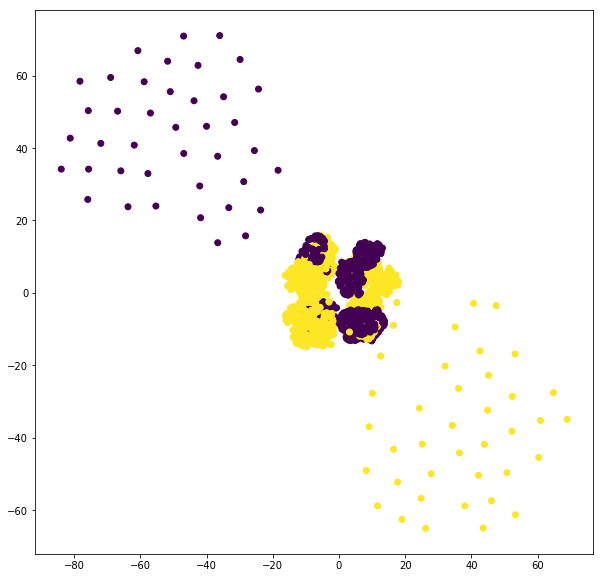

In [2]:
from sklearn.manifold import TSNE

def plot_latent_tsne(autoencoder, data, num_batches=100):
    fig, ax = plt.subplots(figsize=(10,10))
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        z_embedded = TSNE(n_components=2).fit_transform(z)
        ax.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y)


plot_latent_tsne(autoencoder, data)

TSNE повело себя в целом очень даже предсказуемо, поэтому было решено попробовать PCA. 

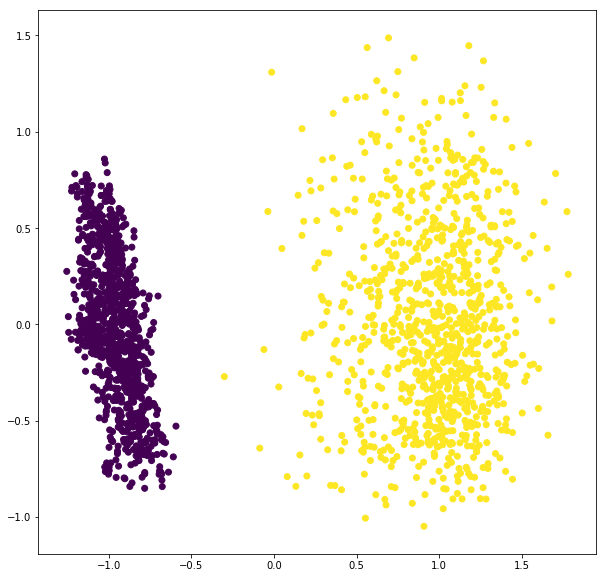

In [3]:
from sklearn.decomposition import PCA
def plot_latent_pca(autoencoder, data, num_batches=100):
    fig, ax = plt.subplots(figsize=(10,10))
    pca = PCA(n_components=2)
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        z_embedded = pca.fit_transform(z)
        ax.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y)
        
plot_latent_pca(autoencoder, data)

Как можно увидеть, и при таком подходе удалось выучить автоэнкодер так, что классы образуют некоторые кластеры в латентном пространстве.